In [1]:
import math
import numpy as np
import scipy
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
# Loading the audio file
signal = scipy.io.wavfile.read("signal.wav")
print(len(signal[1]))
x1 = signal[1]

18091


In [3]:
# Mean subtraction
x0 = np.mean(x1)
x2 = x1 - x0

In [4]:
# Pre-emphasis
x2_temp = np.append(0.0, x2[:len(x2) - 1])
x3 = x2 - 0.97 * x2_temp

In [5]:
# Computing frames
def compute_frames(x3, L, S):
    N = math.ceil((len(x3) - L) / S)
    frames = np.zeros((N + 1, L))
    
    for k in range(N + 1):
        for n in range(L):
            if k * S + n < len(x3):
                frames[k, n] = x3[k * S + n]
    
    
    return frames

In [6]:
# Applying the window function
def apply_window(frame):
    w = scipy.signal.hamming(len(frame))
    return frame * w

In [7]:
# Computing the Fourier transform
def dft(windowed_frame):
    return scipy.fft.fft(windowed_frame, n=512)

In [8]:
# Computing the magnitude and power spectra
def power_spectra(dft_frame):
    return np.square(np.abs(dft_frame))

(23, 257)


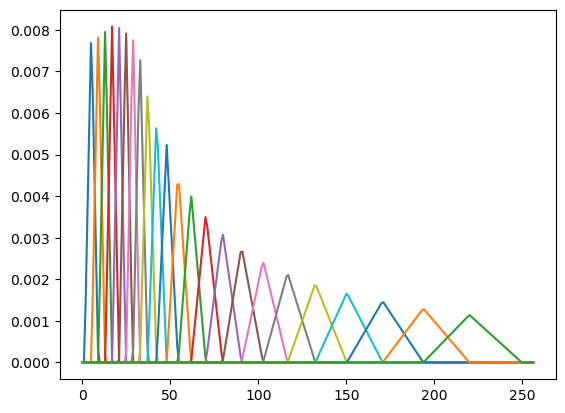

In [9]:
# Mel-filterbank application
mel_filters = np.load("mel_filters.npy")
print(mel_filters.shape)

plt.plot(mel_filters.T)
plt.show()

def mel_filter(X_pow):
    return np.matmul(X_pow[:, :mel_filters.shape[1]], mel_filters.transpose())

In [10]:
# Taking the log
def logmel(X_mel):
    X_logmel = np.empty(X_mel.shape)
    
    for m in range(X_logmel.shape[0]):
        for k in range(X_logmel.shape[1]):
            X_logmel[m, k] = max(-50, np.log10(X_mel[m, k]))
    
    return X_logmel

In [11]:
# Computing the DCT and “liftering”
def dct(X_logmel):
    C = np.zeros((X_logmel.shape[0], 13))
            
    for m in range(C.shape[0]):
        for i in range(C.shape[1]):
            for k in range(X_logmel.shape[1]):
                C[m, i] += X_logmel[m, k] * math.cos(((math.pi * i) / X_logmel.shape[1]) * (k + 0.5))
            
    return C

In [29]:
"""
Putting it all together
"""

def get_mfcc(length_time, shift_time):
    L, S = int(signal[0] * length_time), int(signal[0] * shift_time)

    frames = compute_frames(x3, L, S)
    X_pow = np.empty((frames.shape[0], 512))

    for m in range(X_pow.shape[0]):
        windowed_frame = apply_window(frames[m])
        dft_frame = dft(windowed_frame)
        X_pow[m] = power_spectra(dft_frame)

    X_mel = mel_filter(X_pow)
    X_logmel = logmel(X_mel)
    
    return dct(X_logmel)

MSE: 2.0871469444709202e-26


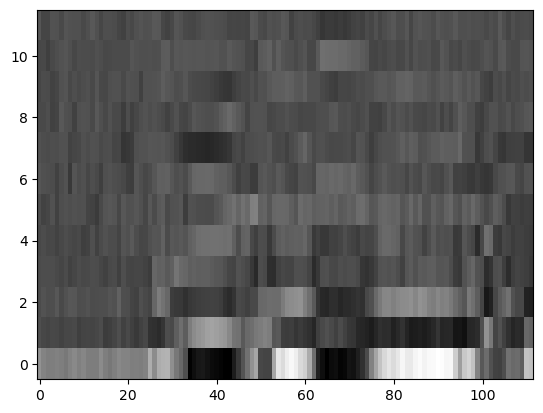

In [53]:
mfcc = get_mfcc(0.025, 0.01)
plt.imshow(mfcc[:, 1:].transpose(), cmap="gist_gray_r", origin="lower", aspect="auto")

mfcc_ref = np.load("reference_mfcc.npy")
mse = (np.square(np.subtract(mfcc_ref, mfcc)).mean())
print("MSE: {}".format(mse))

In [34]:
def plot_logmel(length_time, shift_time):
    L, S = int(16000 * length_time), int(16000 * shift_time)
    
    frames = compute_frames(x3, L, S)
    X_pow = np.empty((frames.shape[0], 512))

    for m in range(X_pow.shape[0]):
        windowed_frame = apply_window(frames[m])
        dft_frame = dft(windowed_frame)
        X_pow[m] = power_spectra(dft_frame)

    X_mel = mel_filter(X_pow)
    
    return logmel(X_mel)


def plot_log_pow_spec(length_time, shift_time):
    L, S = int(16000 * length_time), int(16000 * shift_time)
    
    frames = compute_frames(x3, L, S)
    X_pow = np.empty((frames.shape[0], 512))

    for m in range(X_pow.shape[0]):
        windowed_frame = apply_window(frames[m])
        dft_frame = dft(windowed_frame)
        X_pow[m] = power_spectra(dft_frame)
    
    return logmel(X_pow)

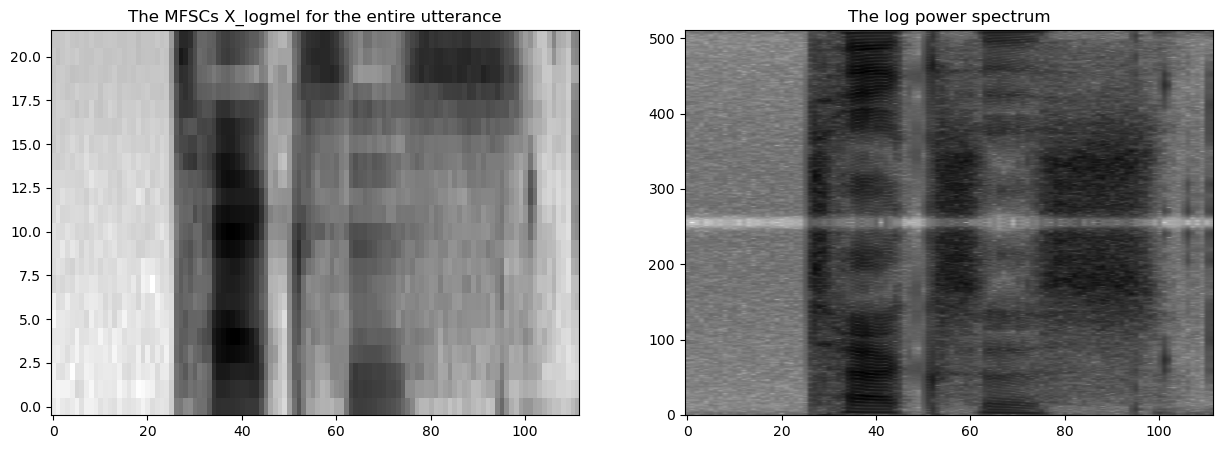

In [72]:
_, axarr = plt.subplots(1, 2, figsize=(15, 5))

#  The MFSCs X_logmel for the entire utterance
axarr[0].set_title("The MFSCs X_logmel for the entire utterance")
axarr[0].imshow(plot_logmel(0.025, 0.01)[:, 1:].transpose(), cmap="gist_gray_r", origin="lower", aspect="auto")

# plot the log power spectrum
axarr[1].set_title("The log power spectrum")
axarr[1].imshow(plot_log_pow_spec(0.025, 0.01)[:, 1:].transpose(), cmap="gist_gray_r", origin="lower", aspect="auto")

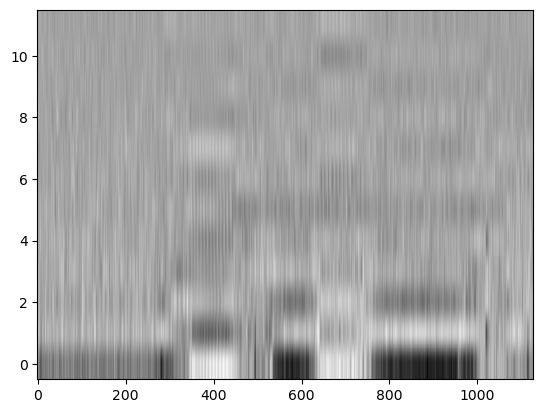

In [69]:
mfcc = get_mfcc(0.004, 0.001)
plt.imshow(mfcc[:, 1:].transpose(), cmap="gray", origin="lower", aspect="auto")


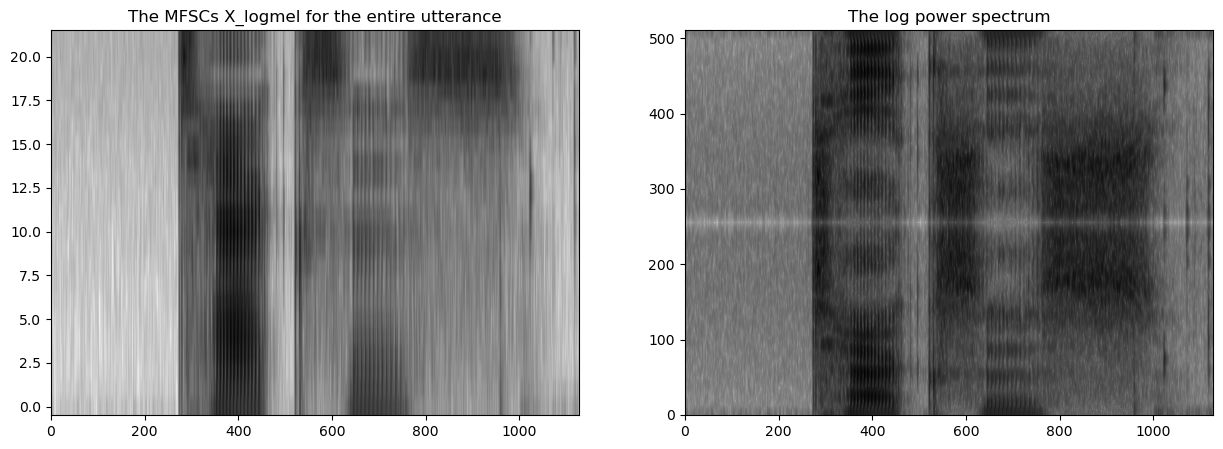

In [74]:
_, axarr = plt.subplots(1, 2, figsize=(15, 5))

axarr[0].set_title("The MFSCs X_logmel for the entire utterance")
axarr[0].imshow(plot_logmel(0.004, 0.001).transpose()[1:], cmap="gist_gray_r", origin="lower", aspect="auto")

axarr[1].set_title("The log power spectrum")
axarr[1].imshow(plot_log_pow_spec(0.004, 0.001).transpose()[1:], cmap="gist_gray_r", origin="lower", aspect="auto")

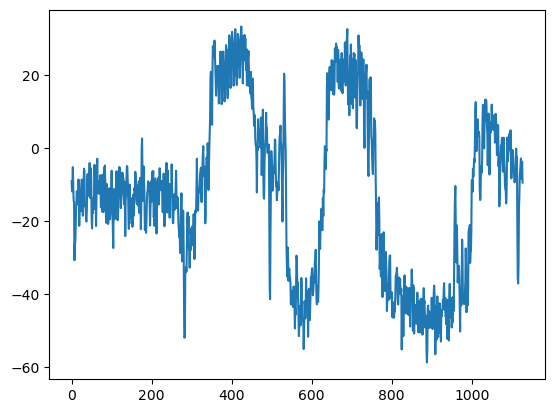

In [76]:
plt.plot(get_mfcc(0.004, 0.001).transpose()[1])